# Exercise Set 7: Fairness

In this exercise set, we will be looking at fairness. 

We first look at fairness with models, focusing first on how to examine a model in relation to fairness criteria (assesment), and then how to post-process a model to make it more fair according to a specific criteria (mitigation). 

After this we look at admission to Berkeley, a classic example demonstrating a fairness analysis with only historical data and no model.

## Fairness with models

In this exercise we will utilize the same dataset as in session 4, Supervised Learning, but this time we will be using the full dataset. The dataset is about classification of high income people, namely the [Census Income Data Set from the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

A large part of these exercises will be dedicated to getting familiar with [fairlearn](https://fairlearn.org/v0.8/user_guide/index.html), which is a package that makes working with fair machine learning easier. In addition to documenting their code, they also have a large amount of examples and text regarding fairness in machine learning in their User Guide.


> **Exercise 1.1**
>
> Based on the code below, what is $Y, X, A$ using the terminology from the lecture? Is $A$ part of $X$, which we will build our model on? If yes, is this required?

In [7]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

# Load data
data = fetch_adult(as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']

# Print data description
print(data.DESCR)

**Author**: Ronny Kohavi and Barry Becker  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Adult) - 1996  
**Please cite**: Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996  

Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

This is the original version from the UCI repository, with training and test sets merged.

### Variable description

Variables are all self-explanatory except __fnlwgt__. This is a proxy for the demographic background of the people: "People with similar demographic characteristics should have similar weights". This similarity-statement is not transferable across the 51 different states.

Description f

In [31]:
data.data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [9]:
print('Target value counts')
print(y_true.value_counts())
print()
print('Sex value counts')
print(sex.value_counts())

Target value counts
0    37155
1    11687
Name: class, dtype: int64

Sex value counts
Male      32650
Female    16192
Name: sex, dtype: int64


In [ ]:
### BEGIN SOLUTION

# X = X, including information such as income, race, sex, age, education, etc.
# Y = y_true, an indicator indicating income higher than 50K
# A = sex, the sex of the observation

# A is part of X. This is not required, but is in general  beneficical if one wants to achieve sufficency.

### END SOLUTION

> **Exercise 1.2**
> 
> We will first create a model to analyze. Create a Decision Tree Classifier with `max_depth=5` and `min_samples_split=50` and fit it on the data. On the basis of this model, predict the outcomes for the same data. 

In [12]:
### BEGIN SOLUTION

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=5, min_samples_split=50)

classifier.fit(X, y_true)

y_pred = classifier.predict(X)

### END SOLUTION

A large part of fairness assesment is looking at metrics across sensitive features. To aid in this, `fairlearn` has a concept which is called a `MetricFrame`, which aids in this.

We will start with perhaps the most basic fairness assesment, looking at performance differences across a metric.

> **Exercise 1.3**
>
> Create a `MetricFrame` with the metric `accuracy_score` you know from `sklearn.metrics`
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> Creating the `MetricFrame` itself won't return any output

In [13]:
### BEGIN SOLUTION

from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

### END SOLUTION

### Assesment

It's nice to work with the `MetricFrame` because it lets us look at performance across the sensitive attribute quickly.

> **Exercise 1.4**
>
> Report the overall accuracy and accuracy by group. Does the model perform equally well across sex?
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> The `MetricFrame` has some useful methods

In [14]:
mf.overall

0.8527087342860653

In [15]:
mf.by_group

sex
Female    0.926630
Male      0.816049
Name: accuracy_score, dtype: float64

Having now looked at accuracy across sex, we want to move closer to the fairness criteria independence and separation.

> **Exercise 1.5**
>
> In addition to the accuracy score, you should now also include the selection rate, false positive rate and false negative rate in your `MetricFrame`. Report them overall and across sex.
>
> Does the model satisfy independence, separation or both? Was this expected?
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> You can input a dictionary where the keys are names and the values are metrics to the `MetricFrame`
>>
>> All three metrics are available in `fairlearn.metrics`

In [37]:
### BEGIN SOLUTION

from fairlearn.metrics import false_positive_rate, false_negative_rate , selection_rate

metrics = {
    "Accuracy": accuracy_score,
    "Selection rate": selection_rate,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
}

mf_multiple = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)

print(mf_multiple.overall)

print(mf_multiple.by_group)

# Does not satisfy independence (equal selection rates) nor separation (equal false positive rate and false negative rate). 
# This is as expected as A is part of X, and thus the model almost certainly obtains sufficiency, and thus generally not independence nor separation.

### END SOLUTION

Accuracy               0.852709
Selection rate         0.163159
False positive rate    0.046777
False negative rate    0.466844
dtype: float64
        Accuracy  Selection rate  False positive rate  False negative rate
sex                                                                       
Female  0.926630        0.058239             0.012549             0.569248
Male    0.816049        0.215191             0.068494             0.448578


When reporting multiple metrics, it can sometimes become hard to maintain an overview of the differences and ratios across the sensitive attribute, but luckily `MetricFrame` can help us with this.

> **Exercise 1.5**
>
>  Report the absolute differences and ratios across sex across the sensitive feature.
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> The `MetricFrame` has some useful methods

In [19]:
mf_multiple.difference()

Accuracy               0.110581
Selection rate         0.156953
False positive rate    0.055944
False negative rate    0.120670
dtype: float64

In [20]:
mf_multiple.ratio()

Accuracy               0.880663
Selection rate         0.270636
False positive rate    0.183220
False negative rate    0.788019
dtype: float64

However, many people find figures nicer to look at than numbers. Let's create one!

> **Exercise 1.6**
>
>  Create a bar plot of the different metrics across sex.
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> The `MetricFrame.by_group` is a `DataFrame`, which means it support bar plots through `plot.bar`.
>>
>> To achieve a nicer bar plot, you can try changing the following keywords: `subplots`, `layout`, `legend`, `figsize` and `title`

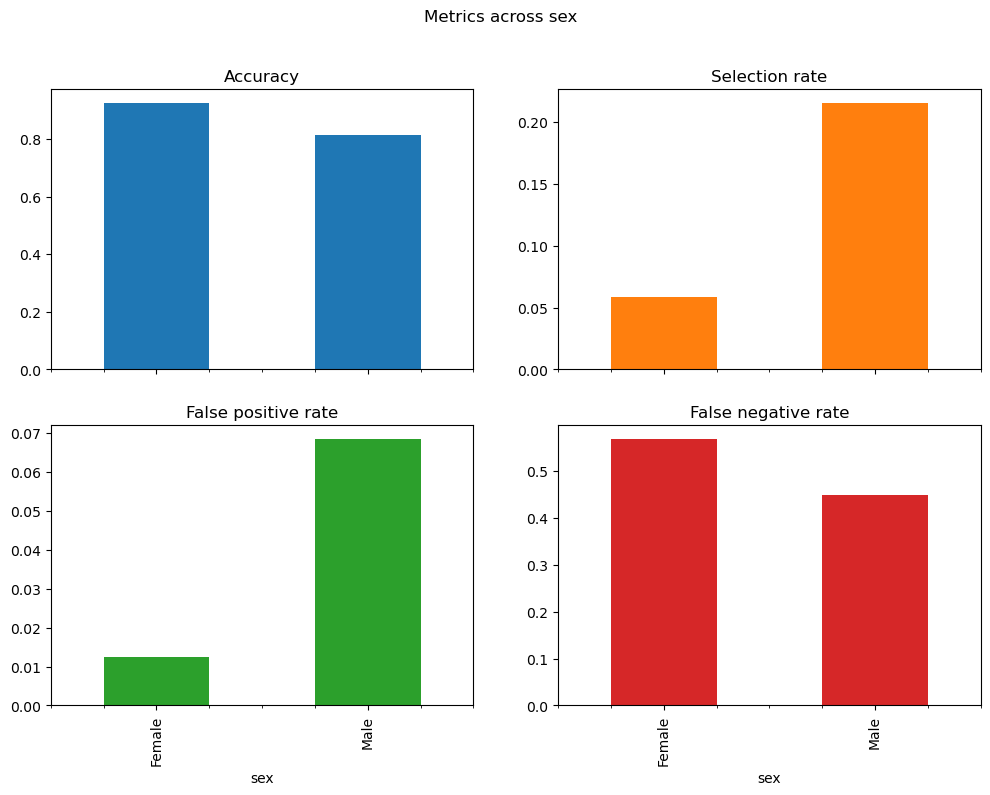

In [40]:
### BEGIN SOLUTION

mf_multiple.by_group.plot.bar(
    subplots=True,
    layout=[2, 2],
    legend=False,
    figsize=[12, 8],
    title="Metrics across sex"
)

plt.show()

### END SOLUTION

### Mitigation

To mitigate fairness concerns, we will utilize the `ThresholdOptimizer` in `fairlearn.postprocessing`, which is based on [Hardt, M., Price, E., & Srebro, N. (2016). Equality of opportunity in supervised learning. Advances in neural information processing systems, 29.](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf). The idea is the one we discussed during the lecture: Using a combination of different thresholds and random classifiers, different fairness criteria can be satisfied, but for more information you should read the paper!

> **Exercise 1.7**
>
>  Post-process the classifier we have created to satisfy demographic parity whilst optimizing accuracy.
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> The `fairlearn` follows the `sklearn` syntax with `.fit` and `.predict`

In [46]:
### BEGIN SOLUTION

from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
                   estimator=classifier,
                   constraints="demographic_parity",
                   objective="accuracy_score")

postprocess_est.fit(X, y_true, sensitive_features=sex)

### END SOLUTION

c:\Users\wkg579\.conda\envs\vive_env\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(estimator=DecisionTreeClassifier(max_depth=4,
                                                    min_samples_split=10))

> **Exercise 1.6**
>
>  Examine the metrics of the post-processed classifier. Does it satisfy independence, and at what selection rate? Has it influenced any of the other metrics? Why is this?
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> Use any method of vizualising metrics across groups that you like

Original classifier
        Accuracy  Selection rate  False positive rate  False negative rate
sex                                                                       
Female  0.926630        0.058239             0.012549             0.569248
Male    0.816049        0.215191             0.068494             0.448578
Post-processed classifier
        Accuracy  Selection rate  False positive rate  False negative rate
sex                                                                       
Female  0.789402        0.221900             0.181446             0.448276
Male    0.804074        0.212956             0.075488             0.471970


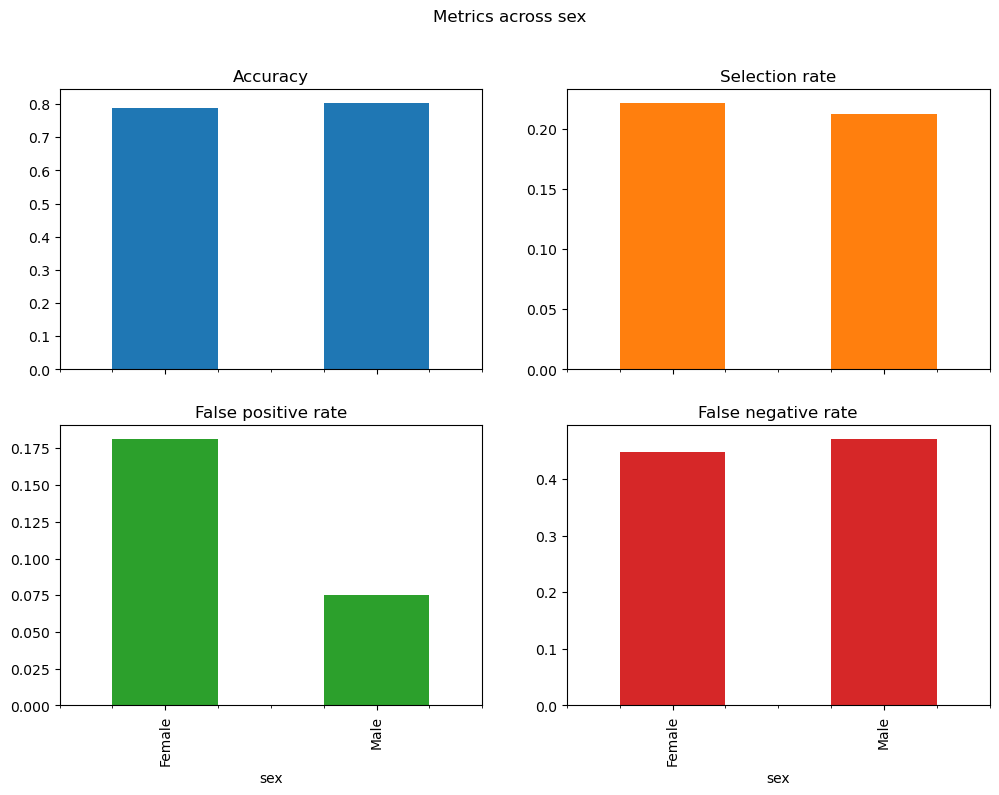

In [49]:
### BEGIN SOLUTION

y_pred_demographic_parity = postprocess_est.predict(X, sensitive_features=sex)

metric_frame_demographic_parity = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_demographic_parity, sensitive_features=sex
)


print('Original classifier')
print(mf_multiple.by_group)
print('Post-processed classifier')
print(metric_frame_demographic_parity.by_group)


metric_frame_demographic_parity.by_group.plot.bar(
    subplots=True,
    layout=[2, 2],
    legend=False,
    figsize=[12, 8],
    title="Metrics across sex",
)

plt.show()

# The model satisfies selection rate at around 21%, which is the original male selection rate
# This has been achieved by increasing the amount of selected females
# However, this has also significantly increased the false positive rate for the females, due to higher acceptance
# No free lunch!

### END SOLUTION

> **Exercise 1.7**
>
>  Repeat the two previous exercises, but now satisfying separation.
> 
>>*Hints:*
>> 
>> [The API Docs](https://fairlearn.org/main/api_reference/index.html) are available online and support searching!
>>
>> separation is also sometimes known as equalized odds.

c:\Users\wkg579\.conda\envs\vive_env\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


Original classifier
        Accuracy  Selection rate  False positive rate  False negative rate
sex                                                                       
Female  0.926630        0.058239             0.012549             0.569248
Male    0.816049        0.215191             0.068494             0.448578
Post-processed classifier
        Accuracy  Selection rate  False positive rate  False negative rate
sex                                                                       
Female  0.880373        0.114872             0.070304             0.521764
Male    0.793691        0.193691             0.069110             0.520770


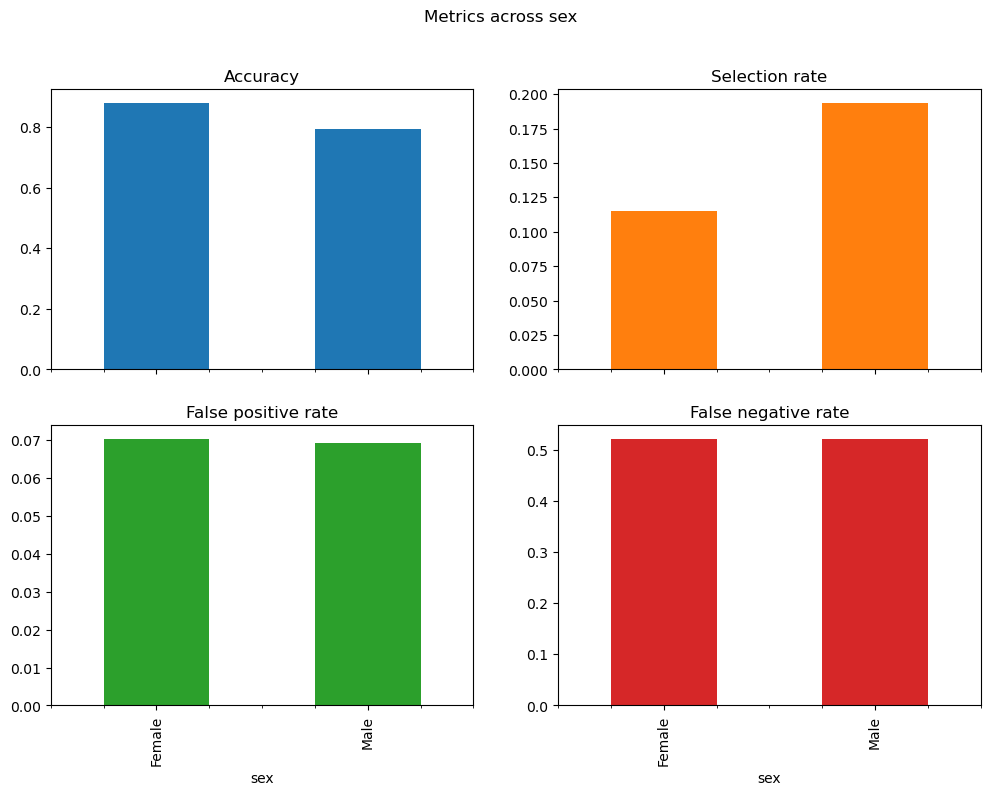

In [50]:
### BEGIN SOLUTION

postprocess_est_equal_odds = ThresholdOptimizer(
                   estimator=classifier,
                   constraints="equalized_odds",
                   objective="accuracy_score")

postprocess_est_equal_odds.fit(X, y_true, sensitive_features=sex)

y_pred_equalized_odds= postprocess_est_equal_odds.predict(X, sensitive_features=sex)


metric_frame_equalized_odds = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_equalized_odds, sensitive_features=sex
)

print('Original classifier')
print(mf_multiple.by_group)
print('Post-processed classifier')
print(metric_frame_equalized_odds.by_group)


metric_frame_equalized_odds.by_group.plot.bar(
    subplots=True,
    layout=[2, 2],
    legend=False,
    figsize=[12, 8],
    title="Metrics across sex",
)

plt.show()

# The model satisfies separation by increasing the false positive rate for females to one equal that of males,
# but has both increased and decreased false negative rates to a middle ground
# This is due to the fact that we examine all classifiers that satisfy separation, and choose the one that maximizes the 
# accuracy score, and this performed the best. 

### END SOLUTION

This ends our voyage with `fairlearn`, but note that `fairlearn` also has implementations of [reduction algorithms](https://fairlearn.org/v0.8/user_guide/mitigation.html#reductions) (which support more fairness constraints and regression fairness) and [intersectionality and control features](https://fairlearn.org/v0.8/user_guide/assessment/intersecting_groups.html).

##  Fairness without models

Sometimes you do not have access to the full modelling process, and merely have observed outcomes. A such example is given the `Berkeley_Admissions_Data.csv` dataset, which is a three-way table that presents admissions data at the University of California, Berkeley in 1973 according to the variables department (A, B, C, D, E, F), gender (male, female), and outcome (admitted, denied) encoded as Yes and No. In this case, we can still assess fairness in some ways.

The exercise is inspired by a similar exercise by my colleague [Roberta Sinatra](https://www.robertasinatra.com/), who also supplied the data, and is based on the original paper [Bickel, P. J., Hammel, E. A., & O'Connell, J. W. (1975). Sex Bias in Graduate Admissions: Data from Berkeley: Measuring bias is harder than is usually assumed, and the evidence is sometimes contrary to expectation. Science, 187(4175), 398-404.](https://homepage.stat.uiowa.edu/~mbognar/1030/Bickel-Berkeley.pdf).

> **Exercise 2.1**
>
>  Load and look at the dataset
> 
>>*Hints:*
>> 
>> `pandas` supports reading many file types.

In [53]:
df = pd.read_csv("Berkeley_Admissions_Data.csv")
df

,Dept,Male Yes,Male No,Female Yes,Female No
0,A,512,313,89,19
1,B,313,207,17,8
2,C,120,205,202,391
3,D,138,279,131,244
4,E,53,138,94,299
5,F,22,351,24,317
6,All,1158,1493,557,1278


> **Exercise 2.2**
> 
> Focusing on Berkeley overall, did their admissions suffer from gender bias?
> 
> Hints: 
>> Subset the row pertaining to all departments
>>
>> What fairness metrics can you calculate with the given information?
>>
>> The code snippet `df["new_col"] = df.apply(lambda x: x["col1"] + x["col2"], axis = 1)` creates a new column called `new_col` which is adds together `x["col1"] + x["col2"]`, which can also be used in combinations with other common operators such as `/`, `-` and `*`. There's an example in exercise 2.3 and code for a plot
>>
>> 

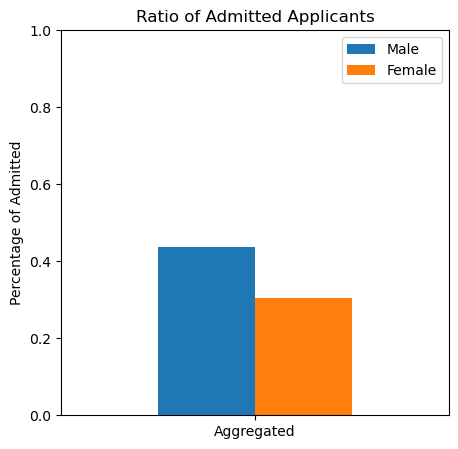

In [54]:
### BEGIN SOLUTION

# Calculate selection rate
df["m_share"] = df.apply(lambda x: x["Male Yes"]/ (x["Male No"] + x["Male Yes"]), axis = 1)
df["f_share"] = df.apply(lambda x: x["Female Yes"]/ (x["Female No"] + x["Female Yes"]), axis = 1)

# Plot
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = df[["Dept","m_share", "f_share"]][df["Dept"] == "All"].plot.bar(ax=ax, title="Ratio of Admitted Applicants", 
                                                      rot=0, ylabel="Percentage of Admitted", ylim=[0,1])
ax.set_xticklabels(["Aggregated"])
ax.legend(["Male", "Female"])

plt.show()

# Looking at the selection rate, we observe indications of discrimination against women, who have a lower selection rate than men. 
# As such, independence is not satisfied

### END SOLUTION

> **Exercise 2.3**
> 
> Now perform a similar analysis within each department. Do you maintain your conclusion from exercise 2.2?
> 
> Hints: 
>> Subsets the rows pertaining to each of the department
>>
>> The code beneath creates a plot with amount of applicants per department. Perhaps this code could be amended to create other plots, or aid in a discussion.
>>
>> Do you find any evidence of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox)?


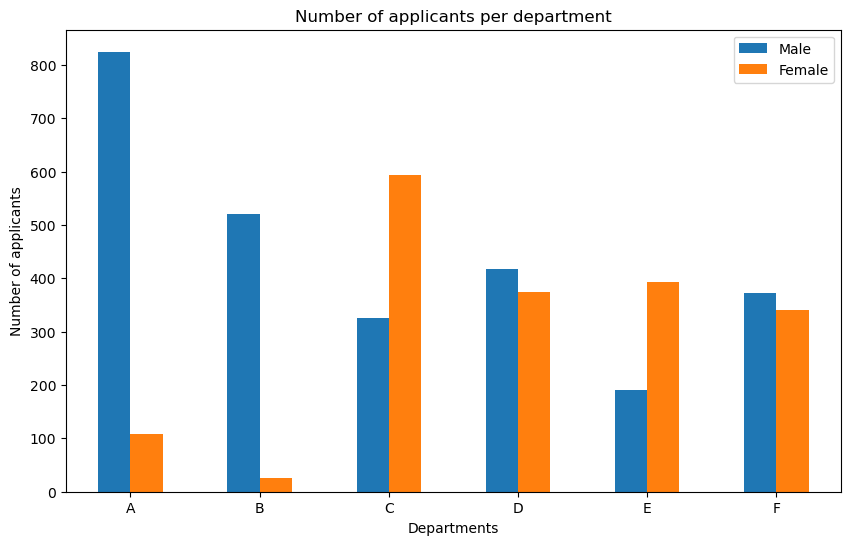

In [55]:
# Calculate amount
df["M_num"] = df.apply(lambda x: x["Male Yes"] + x["Male No"], axis = 1)
df["F_num"] = df.apply(lambda x: x["Female Yes"] + x["Female No"], axis = 1)

# Barplot for first six rows (.iloc[0:6])
fig, ax = plt.subplots(figsize=(10,6))
df[["M_num", "F_num"]].iloc[0:6].plot.bar(title="Number of applicants per department", 
                                                      rot=0, ylabel="Number of applicants", xlabel="Departments", ax=ax)
ax.set_xticklabels(["A", "B", "C", "D", "E", "F"])
ax.legend(["Male", "Female"])
plt.show()

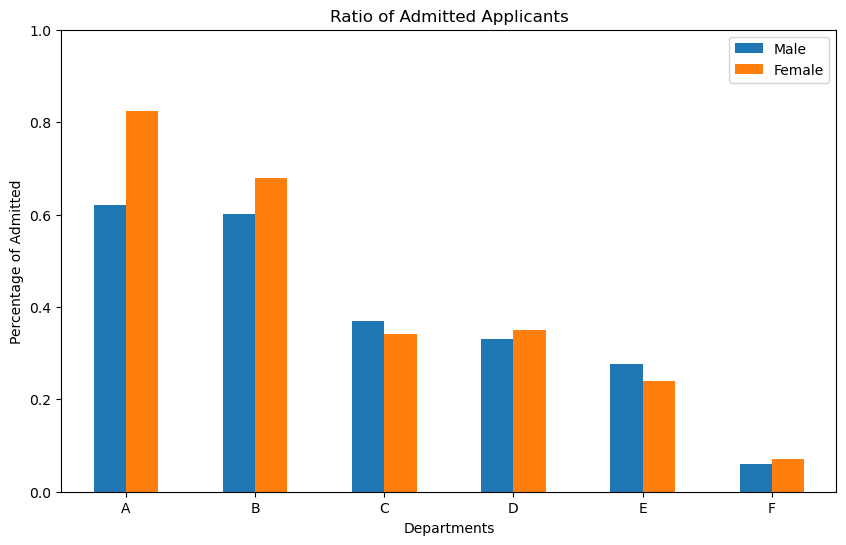

In [58]:
### BEGIN SOLUTION

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax = df[["Dept","m_share", "f_share"]].iloc[0:6].plot.bar(ax=ax, title="Ratio of Admitted Applicants", 
                                                      rot=0, ylabel="Percentage of Admitted", xlabel="Departments", ylim=[0,1])
ax.set_xticklabels(df["Dept"][0:6])
ax.legend(["Male", "Female"])

plt.show()

# Looking at the selection ratio within each department, we see that the general trend observed in the aggregated form disappears
# Some departments exhibit similar acceptance rates for women and men, some department accept more women than men, while some departments accept slightly more men than women.
# Combining this with the figure regading where the different sexes apply, we observe that females were more like to apply to deparments with low acceptance ratios (supposedly more competitive departments)
# These differences in application behaviour explains the apparent gender bias in the aggregated plot. 
# Thus, we can argue that there is no discrimination based on gender
# This is a classic example of Simpson's Paradox, where different levels of aggregation leads to contradicting conclusions

### END SOLUTION